In [2]:
from datasets import load_dataset
import requests
import time
import re
import matplotlib.pyplot as plt
mmlu_ds = load_dataset("cais/mmlu", "all")
df = mmlu_ds["validation"].to_pandas()

In [ ]:
def convert_num_to_letter(num):
    mapping = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}
    return mapping.get(num, None)


In [5]:
response_times = []
correct_flags = []

In [ ]:
import re

def extract_final_answer(model_response: str,kind:str) -> str | None:
    print(f"{kind}:\n{model_response}\n")
    match = re.search(r'Final answer:\s*([a-dA-D])', model_response)
    if match:
        return match.group(1).lower()
    return None


In [ ]:
import random
import json

In [11]:
def ask_local_llm(question: str):
    url = "http://127.0.0.1:8013/generate"
    headers = {"Content-Type": "application/json"}
    payload = {
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": question}
                ]
            }
        ]
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()  
        return response.json()
    except requests.RequestException as e:
        print(f"❌ שגיאה בשליחה לשרת: {e}")
        return None

In [12]:
def send_message_to_backend( request_text: str):

    url = "http://localhost:8002/api/message/add"
    headers = {"Content-Type": "application/json"}
    payload = {
        "userId": "demo_user",
        "request": request_text
    }

    try:
        response = requests.post(url, headers=headers, data=json.dumps(payload))
        response.raise_for_status()
        return response.json()  # מחזירה את התגובה כ־dict
    except requests.RequestException as e:
        print(f"❌ שגיאה בשליחה לשרת הראשי: {e}")
        return None

In [57]:
def run_evaluation(sample_df):
    response_times = []
    correct_flags_s = []
    correct_mlm_flags = []
    for index, row in sample_df.iterrows():
        choices = row["choices"].tolist() if not isinstance(row["choices"], list) else row["choices"]
        gold_letter = convert_num_to_letter(int(row["answer"]))
        
        prompt_M = f"""
    Question: {row['question']}
    Choices:
    a. {choices[0]}
    b. {choices[1]}
    c. {choices[2]}
    d. {choices[3]}

    Answer the question by selecting one option from each of the answers. 
    Briefly explain your reasoning, and then give a final answer of the letter of the selected answer in this exact format:
    Final answer: <letter>
    """
        
        prompt_S =f"""Which of the following answers answers the question?
    Question: {row['question']}
    Choices:
    a. {choices[0]}
    b. {choices[1]}
    c. {choices[2]}
    d. {choices[3]}

    Answer the in this exact format:
    Final answer: <letter>
    """

        try:
            start_time = time.time()
            response = send_message_to_backend(prompt_S)['answer']
            end_time = time.time()
            duration = end_time - start_time
            response_times.append(duration)
            model_output = ask_local_llm(prompt_M)['text']

            pred_s = extract_final_answer(response,"Server")
            pred_m = extract_final_answer(model_output,"LLM")
            if pred_s:
                is_correct = (pred_s == gold_letter)
            else:
                pred_s = "?"
                is_correct = False
            correct_flags_s.append(is_correct)
            if pred_m:
                is_correct = (pred_m == gold_letter)
            else:
                pred_s = "?"
                is_correct = False
            correct_mlm_flags.append(is_correct)
            print(f"[{index}] \nServer: {pred_s} \nLLM:{pred_m} \n---excpected: {gold_letter} in {duration:.2f}s  \n")

            # print(f"Subject:{row['subject']}\n Question: {row['question']} \n Choices:a. {choices[0]}\nb. {choices[1]}\nc. {choices[2]}\nd. {choices[3]}\n\n")

        except Exception as e:
            print(f"[{index}] ❌ error: {e}")
    return response_times, correct_flags , correct_mlm_flags




In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def summarize_and_plot(response_times, correct_flags,correct_mlm_flags):

    accuracy = 100 * sum(correct_flags) / len(correct_flags)
    avg_time = np.mean(response_times)
    median_time = np.median(response_times)
    std_time = np.std(response_times)

    print("\n--- Summary ---")
    print(f"Total questions: {len(response_times)}")
    print(f"Accuracy: {accuracy:.2f}%")


    print("\n----Model LLM---")
    accuracy_mlm = 100 * sum(correct_mlm_flags) / len(correct_mlm_flags)
    print(f"Accuracy: {accuracy_mlm:.2f}%")


# college_biology

In [60]:
sample_df = df[df['subject'] == 'college_biology'].sample(n=10, random_state=42)
response_times, correct_flags ,correct_flags_LLM = run_evaluation(sample_df)

Server :
Final answer: b

LLM :
Final answer: d.

Reasoning: Polyteny, the presence of multiple nuclei within a single somatic cell, is most directly caused by chromosome recombination, specifically crossing over. This process shuffles genetic material, creating new combinations of alleles and leading to multiple nuclei.  RNA transcription, chromatin supercoiling, and cell division are all indirect mechanisms that can contribute to some forms of polyteny, but they are not the primary cause of the phenomenon.

[81] 
Server: b 
LLM:d 
---excpected: c in 1.06s  

Server :
Final answer: c

LLM :
Let’s analyze each statement:

*   **a. The ends of actin filaments move closer together.** This is true – the sliding of actin filaments is a key component of muscle contraction.
*   **b. The length of myosin filaments does not change.** This is true – myosin filaments shorten during contraction, bringing the actin filaments along.
*   **c. Calcium-troponin binding precedes actin-myosin binding.**

In [61]:
summarize_and_plot(response_times, correct_flags,correct_flags_LLM)


--- Summary ---
Total questions: 10
Accuracy: 10.00%
Average time: 1.276 seconds
Median time: 1.045 seconds
Std deviation: 0.336 seconds

----Model LLM---
Accuracy: 30.00%


# anatomy

In [67]:
sample_df = df[df['subject'] == 'anatomy'].sample(n=10, random_state=42)
response_times, correct_flags , correct_LLM = run_evaluation(sample_df)


KeyboardInterrupt: 

In [ ]:
summarize_and_plot(response_times, correct_flags , correct_LLM)


--- Summary ---
Total questions: 10
Accuracy: 10.00%
Average time: 2.196 seconds
Median time: 2.043 seconds
Std deviation: 0.791 seconds

----Model LLM---
Accuracy: 70.00%


# computer_security

# machine_learning

In [68]:
sample_df = df[df['subject'] == 'machine_learning'].sample(n=10, random_state=42)
response_times, correct_flags , correct_LLM = run_evaluation(sample_df)


Server :
Final answer: 0

LLM :
Reasoning: The null space of a matrix is the set of all vectors that, when multiplied by the matrix, result in the zero vector. In this case, the matrix A is diagonal, meaning it has a zero row. Therefore, the null space is the entire space of all vectors, and its dimension is the number of vectors.  Since the matrix is diagonal, there is only one linearly independent column (and thus only one vector), and the null space is the entire space represented by that vector. Thus, the dimensionality of the null space is 1.

Final answer: b

[742] 
Server: ? 
LLM:b 
---excpected: c in 1.13s  

Server :
Final answer: a

LLM :
Final answer: a

Reasoning: Initialization of the weight vector is crucial for proper training. Setting it to zero can lead to overfitting, while allowing it to be a small random value can hinder the exploration of the weight space and potentially slow down the learning process.  Zeroing it prevents bias.

[737] 
Server: a 
LLM:a 
---excpect

In [69]:
summarize_and_plot(response_times, correct_flags , correct_LLM)


--- Summary ---
Total questions: 10
Accuracy: 10.00%
Average time: 1.549 seconds
Median time: 1.129 seconds
Std deviation: 0.813 seconds

----Model LLM---
Accuracy: 20.00%


# professional_accounting

In [70]:
sample_df = df[df['subject'] == 'professional_accounting'].sample(n=10, random_state=42)
response_times, correct_flags , correct_LLM = run_evaluation(sample_df)


Server :
Final answer: $1,000

LLM :
Here's the breakdown of the situation and the correct answer:

**Reasoning:**

Sunshine Corp. purchased the land for $10,000 and sold it for $9,000. This results in a gain or loss. The gain is calculated as:

*   Selling Price - Purchase Price = $9,000 - $10,000 = -$1,000

**Final Answer:** a

[1148] 
Server: ? 
LLM:None 
---excpected: c in 1.52s  

Server :
Final answer: c. Recognizing an amount in its financial statements would weaken the company's defense of the lawsuit.

LLM :
Here's the breakdown of the answer and explanation:

**Reasoning:**

*   **a. No reasonable estimate of the loss can be made:** This is a fundamental principle of accrual accounting. If a reasonable estimate is impossible, the loss shouldn't be recorded.
*   **b. An estimated range for the loss can be made but no amount in the range is more accurate than any other amount:** This aligns with the matching principle – recognizing the loss only when it’s reliably estimated.
* 

In [71]:
summarize_and_plot(response_times, correct_flags , correct_LLM)


--- Summary ---
Total questions: 10
Accuracy: 10.00%
Average time: 2.336 seconds
Median time: 2.236 seconds
Std deviation: 0.987 seconds

----Model LLM---
Accuracy: 0.00%


# high_school_european_history

In [72]:
sample_df = df[df['subject'] == 'high_school_european_history'].sample(n=10, random_state=42)
response_times, correct_flags , correct_LLM = run_evaluation(sample_df)


Server :
Final answer: b

Explanation: The document describes how Italy’s unification was a significant event that discarded its imperial traditions, leading to Rome becoming the head of an Italian kingdom, which was a pivotal moment in European history. Giuseppe Garibaldi and Victor Emmanuel Cavour are not mentioned in this text.

LLM :
Final answer: b

Reasoning: The text heavily critiques the forceful and rapid unification of Italy, highlighting the suppression of independent identities and the abandonment of traditional power structures. Napoleon III is generally viewed as advocating for expansion and centralized control, which contrasts sharply with the author's critique of a hasty and somewhat destructive unity. Giuseppe Garibaldi, while a key figure in Italian unification, was more focused on popular uprisings and territorial gains than the systematic dismantling of existing kingdoms. Victor Emmanuel Cavour was primarily concerned with consolidating power within a single nation,

In [73]:
summarize_and_plot(response_times, correct_flags , correct_LLM)


--- Summary ---
Total questions: 10
Accuracy: 10.00%
Average time: 3.223 seconds
Median time: 2.656 seconds
Std deviation: 2.226 seconds

----Model LLM---
Accuracy: 70.00%


In [74]:
sample_df

,question,subject,choices,answer
353,This question refers to the following informat...,high_school_european_history,"[Napoleon III, Giuseppe Garibaldi, Victor Emma...",1
354,This question refers to the following informat...,high_school_european_history,"[Utilitarians, Laissez-faire capitalists, Utop...",2
361,This question refers to the following informat...,high_school_european_history,[New concepts of legal equity and individual r...,1
358,This question refers to the following informat...,high_school_european_history,"[Unify Italy with his brother as king, Punish ...",2
356,This question refers to the following informat...,high_school_european_history,[The suppression of all new ideas in every fie...,1
366,This question refers to the following informat...,high_school_european_history,[The introduction of machines did not increase...,1
369,This question refers to the following informat...,high_school_european_history,"[Papal wealth, Pluralism, Nepotism, Indulgences]",0
368,This question refers to the following informat...,high_school_european_history,[In some of the less industrialized areas of E...,3
364,This question refers to the following informat...,high_school_european_history,"[the spread of mechanical power in industry, t...",2
355,This question refers to the following informat...,high_school_european_history,[the Russian military had to launch a new offe...,2


# high_school_world_history

In [ ]:
sample_df = df[df['subject'] == 'high_school_world_history'].sample(n=10, random_state=42)
response_times, correct_flags , correct_LLM = run_evaluation(sample_df)


In [ ]:
summarize_and_plot(response_times, correct_flags , correct_LLM)

In [64]:
subjects = df['subject'].unique()
subjects

array(['anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge',
       'college_biology', 'college_chemistry', 'college_computer_science',
       'college_mathematics', 'college_medicine', 'college_physics',
       'computer_security', 'conceptual_physics', 'econometrics',
       'electrical_engineering', 'elementary_mathematics', 'formal_logic',
       'global_facts', 'high_school_biology', 'high_school_chemistry',
       'high_school_computer_science', 'high_school_european_history',
       'high_school_geography', 'high_school_government_and_politics',
       'high_school_macroeconomics', 'high_school_microeconomics',
       'high_school_physics', 'high_school_psychology',
       'high_school_statistics', 'high_school_us_history',
       'high_school_world_history', 'human_aging', 'human_sexuality',
       'international_law', 'jurisprudence', 'logical_fallacies',
       'machine_learning', 'management', 'marketing', 'medical_genetics',
       'miscellaneous', 'moral_dispute

In [65]:

def convert_num_to_letter(num):
    mapping = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}
    return mapping.get(num, None)
def send_to_api(data):
    url = "http://localhost:8002/api/message/add"
    response = requests.post(url, json=data)
    return response.json()

response_times = []
correct_flags = []
for index, row in df.iterrows():
    choices = row["choices"].tolist() if not isinstance(row["choices"], list) else row["choices"]
    gold_letter = convert_num_to_letter(int(row["answer"]))
     
    prompt = f"""
Question: {row['question']}
Choices:
a. {choices[0]}
b. {choices[1]}
c. {choices[2]}
d. {choices[3]}

Respond only answer with the letter (a, b, c, d) of the correct answer. 
Do not write words or explanations - only the appropriate letter.
"""

    data = {
        "request": prompt,       
        "userId": "test_user"    
    }

    try:
        start_time = time.time()
        response = send_to_api(data)
        end_time = time.time()
        duration = end_time - start_time
        response_times.append(duration)

        model_output = str(response)
        match = re.search(r"\b([abcd])\b", model_output.lower())
        if match:
            pred_letter = match.group(1)
            is_correct = (pred_letter == gold_letter)
        else:
            pred_letter = "?"
            is_correct = False        print(f"[{index}] answer: {response['answer']} excpected: {gold_letter} in {duration:.2f}s")


        correct_flags.append(is_correct)
    except Exception as e:
        print(f"[{index}] ❌ error: {e}")
    if index <= 19 :
        print(f"Question: {row['question']} \n Choices: \n a. {choices[0]}\n b. {choices[1]}\n c. {choices[2]}\n d. {choices[3]}")
    if index >= 30:
        break
    



SyntaxError: invalid syntax (3772636656.py, line 46)


--- Summary ---
Total questions: 1531
Accuracy: 31.03%
Average time: 0.562 seconds
Median time: 0.575 seconds
Std deviation: 0.213 seconds


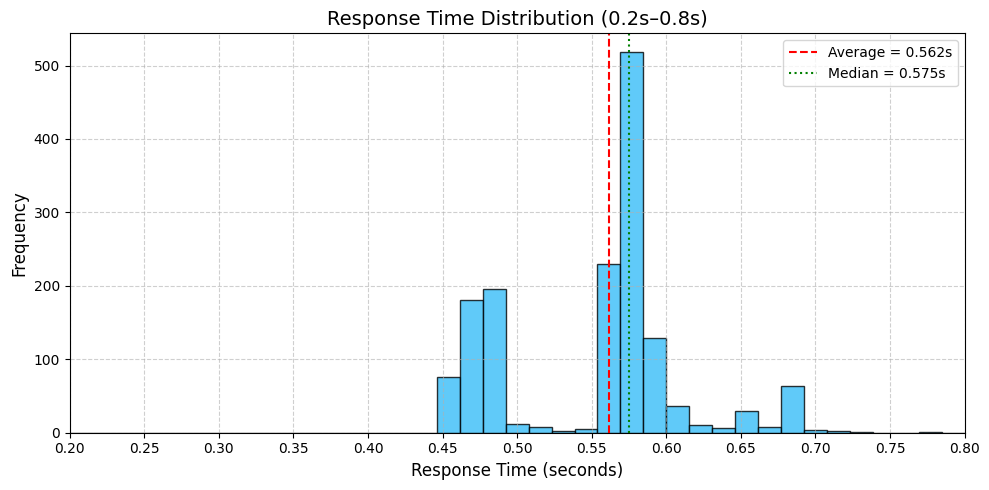

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Summary ===
accuracy = 100 * sum(correct_flags) / len(correct_flags)
avg_time = np.mean(response_times)
median_time = np.median(response_times)
std_time = np.std(response_times)

print("\n--- Summary ---")
print(f"Total questions: {len(response_times)}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Average time: {avg_time:.3f} seconds")
print(f"Median time: {median_time:.3f} seconds")
print(f"Std deviation: {std_time:.3f} seconds")

# === Histogram ===
plt.figure(figsize=(10, 5))

# קובעים טווח מדויק של 0.2 עד 0.8 שניות
min_t, max_t = 0.2, 0.8
bins = np.linspace(min_t, max_t, 40)  # 40 חלוקות לטווח קטן – דיוק גבוה

# סינון הערכים בתוך הטווח בלבד
filtered_times = [t for t in response_times if min_t <= t <= max_t]

plt.hist(filtered_times, bins=bins, color='#38bdf8', edgecolor='black', alpha=0.8)
plt.title("Response Time Distribution (0.2s–0.8s)", fontsize=14)
plt.xlabel("Response Time (seconds)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# קווים ממוצע וחציון
plt.axvline(avg_time, color='red', linestyle='--', linewidth=1.5, label=f'Average = {avg_time:.3f}s')
plt.axvline(median_time, color='green', linestyle=':', linewidth=1.5, label=f'Median = {median_time:.3f}s')
plt.legend()

# הצגת טיקים מדויקים
plt.xlim(min_t, max_t)
plt.xticks(np.round(np.linspace(min_t, max_t, 13), 3))

plt.tight_layout()
plt.show()
